<a href="https://colab.research.google.com/github/haopham6798/IoT_Intrusion_Detection_System/blob/main/Sklearn_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import các thư viện

In [ ]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import joblib
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import re
import csv
import matplotlib.pyplot as plt 
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Khai báo các hàm cần dùng

In [ ]:
#dict chuyển label từ chuỗi sang số
attack_category = {
        'Normal': 0,
        'Fuzzers': 1, 
        'Reconnaissance': 2, 
        'Shellcode': 3, 
        'Exploits': 4, 
        'Worms': 5, 
        'DoS': 6, 
        'Backdoor': 7, 
        'Analysis': 8, 
        'Generic': 9, 
  }

#load tập dữ liệu
def load_data(filepath):
    try:
        return pd.read_csv(filepath, delimiter=',',low_memory=False)
    except:
        print("File Not Found")
        return

#tách nhãn
# def split_label_trainset(dataset):
#     #split label column
#     l =len(dataset.columns) - 1
#     label_list = dataset.iloc[:,-1]
#     data_list = dataset.iloc[:,0:l]
#     return data_list, label_list

#split dataset to trainset and testset
def train_test_splitor(data, per):
    total_rows = data.shape[0]
    random_id_list= np.random.permutation(total_rows)
    train_idx = random_id_list[0:int(per*total_rows)]
    test_idx = random_id_list[int(per*total_rows):-1]
    train_data = data.iloc[train_idx,:]
    test_data = data.iloc[test_idx,:]
    return train_data, test_data

#xóa các dòng giá trị NaN
def drop_nan(df):
    features = df.columns#.drop("label")
    for f in features:
        df.loc[df[f] == '-', f] = np.nan
    df.dropna(inplace=True)

#xóa các dòng có thuộc tính trong tập dữ liệu được lưu dưới dạng hex
def clear_hex_value(df,col):
    cols = df[col].items()
    for index, value in cols:
        if isinstance(value, int):
            pass
        else:
            r = int(str(value),0)
            df = df.replace(to_replace=value, value=r)


#chuyển thuộc tính state từ chuỗi sang số
def encode_state(df):
    le = preprocessing.LabelEncoder()
    state_list = ['ECO', 'ECR', 'CON', 'INT', 'TST', 'MAS', 'no', 'PAR', 'RST', 'ACC', 'URN', 'FIN', 'URH', 'REQ', 'CLO', 'TXD',]
    lenc = le.fit(state_list)
    df["state"] = le.fit_transform(df["state"])

#chuyển thuộc tính proto sang number theo 1 danh sách proto_num được đánh số trước  
def get_number_proto():
    file_proto_num = "./drive/My Drive/dataset/proto_num.csv"
    #proto_num = load_data(file_proto_num)
    f = csv.reader(open(file_proto_num, 'r'))
    pro_num = dict()
    for row in f:
        if row[1] != "":
            k = row[1].lower()
            v = row[0]
            pro_num[k] = v
        else:
            continue
    del pro_num['keyword']
    return pro_num



#hàm phân tích tập dữ liệu
def analyze(df, attack_category):
  # att_netflow = df[df["attack_cat"] >= 1]
  print("The number of total records is: {}".format(len(df)))
  # print("The number of attacked records is: {}".format(len(att_netflow)))
  for key,value in attack_category.items():
    temp = df[df['attack_cat'] == key ]
    print("The number of {0} records is: {1}".format(key, len(temp)))


#hàm tính toán 
def cal_att_score(predictions, attack_category):
  att_cate = dict()
  for key,value in attack_category.items():
    sum = 0
    for pre in predictions:
      if pre == value:
        sum+=1
    att_cate[key] =  sum
  return att_cate


In [ ]:
#tất cả thuộc tính của tập dữ liệu UNSW-NB15(https://research.unsw.edu.au/projects/unsw-nb15-dataset)
features = ['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'sload', 'dload', 'spkts', 'dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'sjit', 'djit', 'stime', 'ltime', 'sintpkt', 'dintpkt', 'tcprtt', 
'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat', 'label']

#các thuộc tính argus sinh ra realtime
argus_fields = [
    "sport", "dport","dur", "proto", "state", "spkts", "dpkts", "sbytes", "dbytes", "sttl", "dttl", "sload", "dload", "sloss", "dloss", "sintpkt", "dintpkt", "sjit", "djit", "swin", "dwin", "stcpb", "dtcpb", "tcprtt", "synack", "ackdat", "smeansz", "dmeansz","stime", "ltime","attack_cat","label"
]

In [ ]:
print(len(features))
print(len(argus_fields))

49
32


Load dữ liệu và xử lý dữ liệu

In [ ]:
path = "./drive/My Drive/LVan/DIoT/"
filepath = path+ "Dataset/UNSW/UNSW-train-multi-20-251220.csv"
proto_num = get_number_proto()
dt = load_data(filepath)
data = dt.replace({"proto": proto_num})
encode_state(data)

data = data.fillna(0)

#giảm số thuộc tính cần lấy lại (20 thuộc tính)
argus_fields_att = [
    "sport", "dport","dur", "proto", "state", "spkts", "dpkts", "sbytes", "dbytes", "sttl", "dttl", "sload", "dload", "sloss", "dloss", "tcprtt", "synack", "ackdat", "smeansz", "dmeansz","attack_cat",
]
dataset =data[argus_fields_att]


drop_nan(dataset)
print(dataset.shape)
dataset["proto"]= pd.to_numeric(dataset["proto"], downcast='float')
dataset["sport"]= pd.to_numeric(dataset["sport"], downcast='float')
dataset["dport"]= pd.to_numeric(dataset["dport"], downcast='float')
#dataset.drop(dataset[dataset['attack_cat'] =="Normal"].index, inplace = True)
print(dataset.shape)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(2539735, 21)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(2539735, 21)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Tách dữ liệu thành 2 tập train và test

In [ ]:

x_train , x_test = train_test_splitor(dataset, 0.8)

print("Training set")
analyze(x_train, attack_category)
print("=====================================")
print("\nTesting set")
analyze(x_test,attack_category)

y_train = x_train.pop("attack_cat")
x_train =  preprocessing.normalize(x_train)


y_test = x_test.pop("attack_cat")
x_test =  preprocessing.normalize(x_test)
# print(x_train.shape)
# print(x_test.shape)

# x_train = preprocessing.normalize(dftrain)




Training set
The number of total records is: 2031788
The number of Normal records is: 1774848
The number of Fuzzers records is: 19445
The number of Reconnaissance records is: 11221
The number of Shellcode records is: 1232
The number of Exploits records is: 35618
The number of Worms records is: 128
The number of DoS records is: 13165
The number of Backdoor records is: 1850
The number of Analysis records is: 2138
The number of Generic records is: 172143

Testing set
The number of total records is: 507946
The number of Normal records is: 443604
The number of Fuzzers records is: 4801
The number of Reconnaissance records is: 2766
The number of Shellcode records is: 279
The number of Exploits records is: 8907
The number of Worms records is: 46
The number of DoS records is: 3188
The number of Backdoor records is: 479
The number of Analysis records is: 539
The number of Generic records is: 43337


In [ ]:
#train all dataset
# analyze(dataset,attack_category )
# y_train = dataset.pop("attack_cat")
# x_train =  preprocessing.normalize(dataset)

Huấn luyện mô hình phân loại

In [ ]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

#Random Forest(https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
#criterion="gini" -> The function to measure the quality of a split (có 2 loại gini và entropy)
#random_state=0 -> Controls both the randomness of the bootstrapping of the samples used when building trees (giá trị có thể là 1 số nguyên ngẫu nhiên)
clf = RandomForestClassifier( criterion="gini",random_state=42)


#Decision Tree(https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
#criterion="gini" -> The function to measure the quality of a split (có 2 loại gini và entropy)
#random_state=0 -> Controls both the randomness of the bootstrapping of the samples used when building trees (giá trị có thể là 1 số nguyên ngẫu nhiên)
#splitter="best" -> The strategy used to choose the split at each node. Supported strategies are “best” to choose the best split and “random” to choose the best random split
#clf = DecisionTreeClassifier(criterion="gini", splitter="best", random_state=0)

#Naive Bayes (https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
#các giá trị để theo default
#clf = GaussianNB()

clf.fit(x_train, y_train)


#xuat mo hinh 
# filename = path + '/Model/2021-06-09-dec-clf.sav'
# joblib.dump(clf, filename)

The scikit-learn version is 0.22.2.post1.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Tính độ chính xác của mô hình phân loại

In [ ]:
clf.score(x_test,y_test)
# path = clf.decision_path(x_test)
predictions = clf.predict(x_test)
score = accuracy_score(y_test,predictions)
conf = confusion_matrix(y_test, predictions)
print(score)



0.975788764947455


In [ ]:
# predictions = clf.predict(dftest)
# score = accuracy_score(y_test,predictions)
# conf = confusion_matrix(y_test, predictions)
# conf_df = pd.DataFrame(conf, index=[0,1,2,3,4,5,6,7,8,9], columns=[0,1,2,3,4,5,6,7,8,9])
# print(score)
# diagonal = list()
# for i in range(10):
#   diagonal.append(conf_df.iloc[i][i])
# print(diagonal)

# print(conf)
# att_score = cal_att_score(predictions, attack_category)
# print(att_score)

In [ ]:
# true_label = pd.Series(y_test).value_counts().sort_index()
# # print(pre.value_counts().sort_index())
# # print(true_label.value_counts().sort_index())
# att_label = [ 'Normal','Fuzzers', 'Reconnaissance', 'Shellcode', 'Exploits', 'Worms', 'DoS', 'Backdoors', 'Analysis', 'Generic']
# frame = {'Prediction': predictions, 'True Label': y_test}
# result_df = pd.DataFrame(frame)
# #result_df.index = index_
# result_df.plot.bar(figsize=(5, 5), title="Percentage Of Attack Types", grid=True)
# #plt.savefig(path+'Result/percent-RF'+'.jpg')
# plt.show()

Report

In [ ]:
from sklearn.metrics import classification_report

key_att_category = list(attack_category.keys())
clf_report = classification_report(y_test, predictions, labels=key_att_category)
print(clf_report)

                precision    recall  f1-score   support

        Normal       0.98      1.00      0.99    443604
       Fuzzers       0.69      0.43      0.53      4801
Reconnaissance       0.85      0.48      0.61      2766
     Shellcode       0.83      0.59      0.69       279
      Exploits       0.67      0.73      0.70      8907
         Worms       0.67      0.09      0.15        46
           DoS       0.51      0.08      0.13      3188
      Backdoor       0.74      0.05      0.09       479
      Analysis       0.80      0.10      0.18       539
       Generic       0.99      0.98      0.99     43337

      accuracy                           0.98    507946
     macro avg       0.77      0.45      0.51    507946
  weighted avg       0.97      0.98      0.97    507946



In [ ]:
key_att_category = list(attack_category.keys())
print(key_att_category)

['Normal', 'Fuzzers', 'Reconnaissance', 'Shellcode', 'Exploits', 'Worms', 'DoS', 'Backdoor', 'Analysis', 'Generic']


Vẽ Confusion Matrix

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


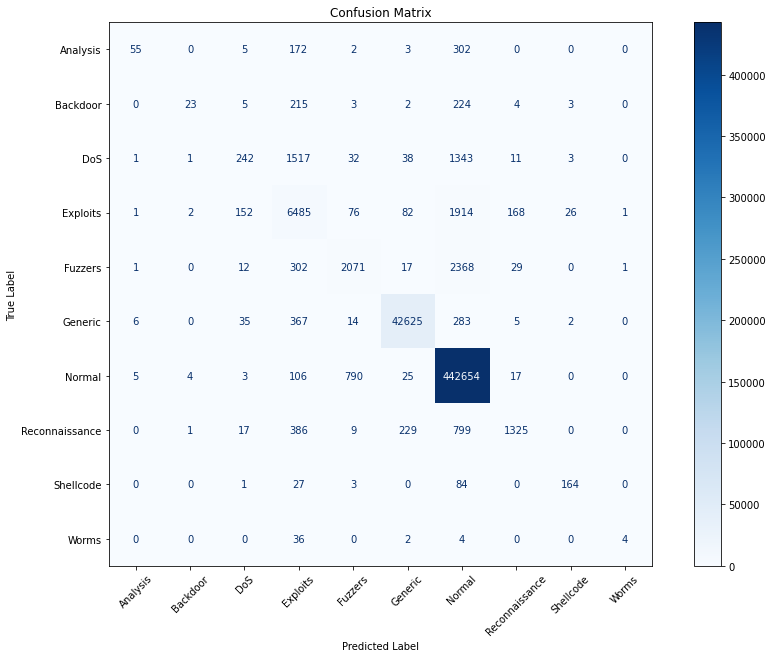

In [ ]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import joblib
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import re
import csv
import matplotlib.pyplot as plt 
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from google.colab import drive
drive.mount('/content/drive')

fig, ax = plt.subplots(figsize=(15, 10))
plt.title('Confusion Matrix')
plot_confusion_matrix(clf, x_test, y_test, xticks_rotation=45,cmap=plt.cm.Blues,ax=ax,values_format = '')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')

#set label for x,y
ax.set_xlabel('Predicted Label', fontsize='medium')
ax.set_ylabel('True Label', fontsize='medium')
#save figure
plt.savefig('./drive/My Drive/LVan/DIoT/Reports/confusion_matrix-rf.jpg')
plt.show()